In [40]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from imp import reload
from scipy.stats import entropy
%matplotlib inline

import numba

from info_measures import dataset_generators as dg

In [14]:
# Load and remove zeros
mnist = input_data.read_data_sets('.', one_hot=True, validation_size=0, reshape=False)
X = mnist.train.images
X = X[:,2:-2:2,2:-2:2]

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [15]:
reload(dg)

dg_mnist = dg.ImageGenerator(X, grow_axis=2)

In [16]:
print(dg_mnist.X.shape)
print(dg_mnist.symmetry_axes)

(60000, 12, 12, 1)
[1, 2]


In [18]:
dim = 4
perp_dim = 7
samples = dg_mnist.sample_data(dim, perp_dim=perp_dim)

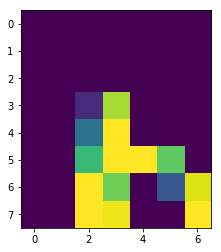

In [19]:
plt.imshow(samples[0].reshape(2*dim, perp_dim))

In [102]:
reload(dg)
dg_vec = dg.VectorSpaceGenerator(X)
numba.config.NUMBA_NUM_THREADS = 4

In [103]:
xp = dg_vec.sample_data(grow_dim=7, n_samples_per_image=1)

In [31]:
xp = dg_vec.sample_data2(grow_dim=3, n_samples_per_image=1)

In [32]:
xp = dg_vec.sample_data3(grow_dim=3, n_samples_per_image=1)

In [70]:
%timeit dg_vec.sample_data(grow_dim=3, n_samples_per_image=)

43.5 ms ± 3.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
%timeit dg_vec.sample_data2(grow_dim=3, n_samples_per_image=1)

1.35 s ± 3.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%timeit dg_vec.sample_data3(grow_dim=3, n_samples_per_image=1)

1.36 s ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


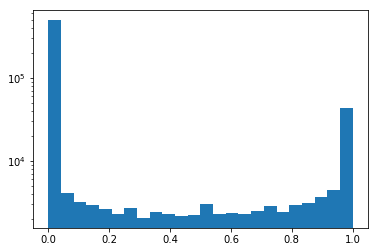

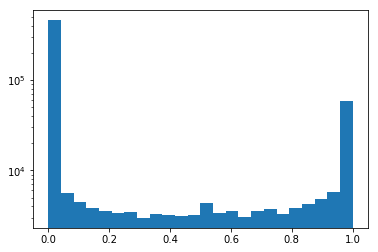

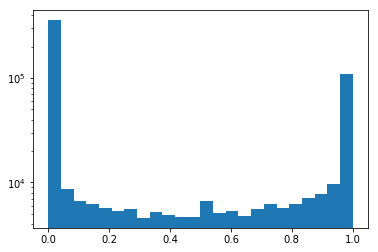

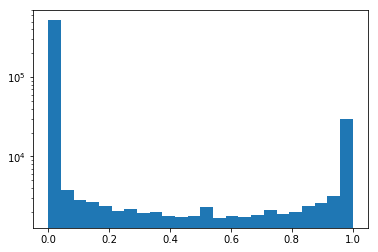

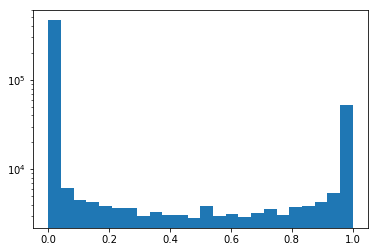

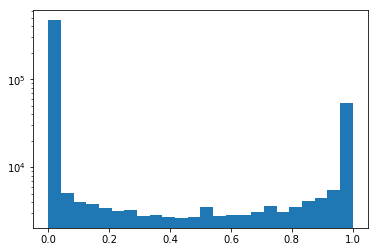

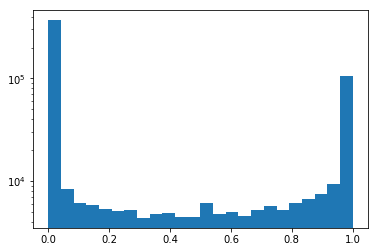

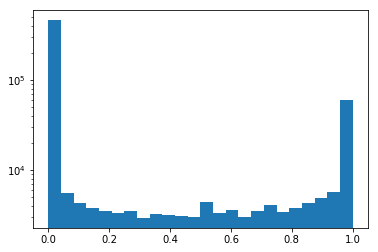

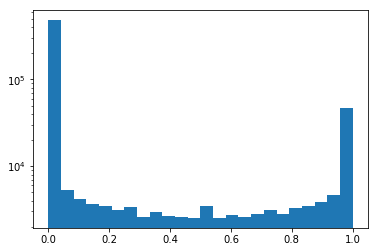

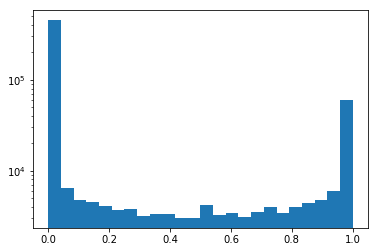

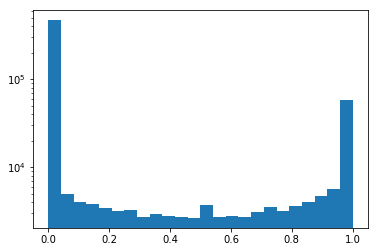

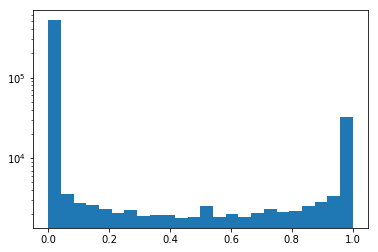

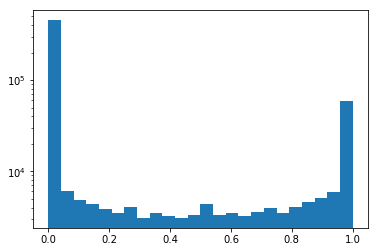

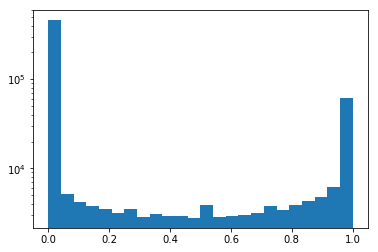

In [81]:
pdfs = []
for ii in range(14):
    plt.figure()
    pdf, _, _ = plt.hist(xp[:, ii], bins=np.linspace(0, 1, 25))
    pdfs.append(pdf)
    plt.yscale('log')
    plt.figure()

In [82]:
im = np.zeros((14, 14))
im2 = np.zeros((14, 14))
for ii in range(14):
    for jj in range(ii):
        im[ii, jj] = entropy(pdfs[ii], pdfs[jj])
        im2[ii,jj] = np.dot(xp[:,ii,0]-xp[:,ii,0].mean(), xp[:,jj]-xp[:,jj].mean())

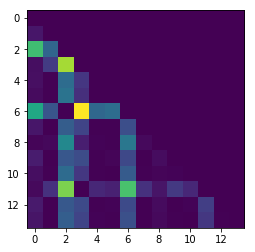

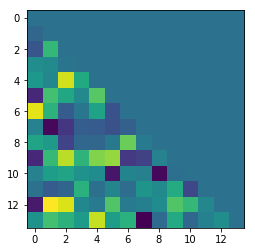

In [84]:
plt.imshow(im/entropy(pdfs[0]))
plt.figure()
plt.imshow(im2)

In [104]:
xp = np.squeeze(xp)

In [100]:
norms = np.linalg.norm(xp, axis=1)

In [101]:
xp = xp[norms > 0]

In [94]:
np.linalg.norm(xp, axis=1, keepdims=True).shape

(60000, 1)

In [95]:
xp.T.dot(xp)

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  na

In [96]:
xp

array([[ 0.        ,  0.        ,  0.41700381, ...,  0.        ,
         0.        ,  0.54103569],
       [ 0.        ,  0.        ,  0.        , ...,  0.03249683,
         0.43058292,  0.        ],
       [ 0.        ,  0.14340058,  0.11413515, ...,  0.        ,
         0.        ,  0.68481092],
       ..., 
       [ 0.        ,  0.        ,  0.43557882, ...,  0.        ,
         0.        ,  0.45537785],
       [ 0.        ,  0.4531996 ,  0.        , ...,  0.49851956,
         0.02132704,  0.33856677],
       [ 0.        ,  0.5413281 ,  0.        , ...,  0.        ,
         0.        ,  0.71797204]])